In [9]:
import pandas as pd
import wfdb
import numpy as np
import argparse
ekg_data = pd.read_csv('SUB_ICON_01010001_20210905_091338_ECG_AFIB_raw_250Hz.csv', header=None)
ekg_values = ekg_data.values[:,1] + 170
timestamps = ekg_data.values[:,0]
signals = np.array([ekg_values]).T

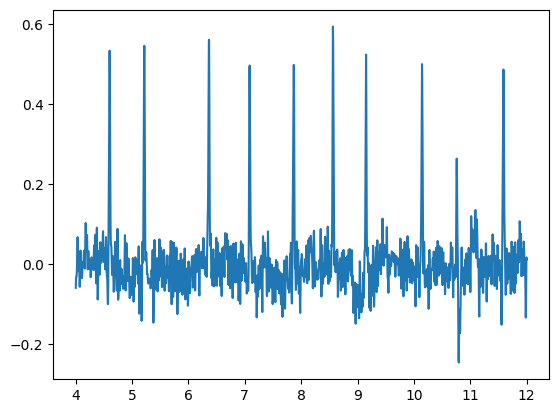

In [10]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Define the filter parameters
fs = 250  # Sampling frequency (Hz)
lowcut = 0.5  # Low cutoff frequency (Hz)
highcut = 50  # High cutoff frequency (Hz)
order = 4  # Filter order

# Normalize the cutoff frequencies
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Design the low-pass filter
b, a = butter(order, [low, high], btype='band', analog=False)

# Apply the filter to the EKG signal
filtered_ekg = filtfilt(b, a, ekg_values)
plt.plot(timestamps[1000:3000], filtered_ekg[1000:3000])

[comments]
* baseline noise still exist
* apply notched filter (fail)

[comments]
* apply arma, but fail

[comments]
* apply simple moving average
* baseline noise is removed, but qrs also affected.

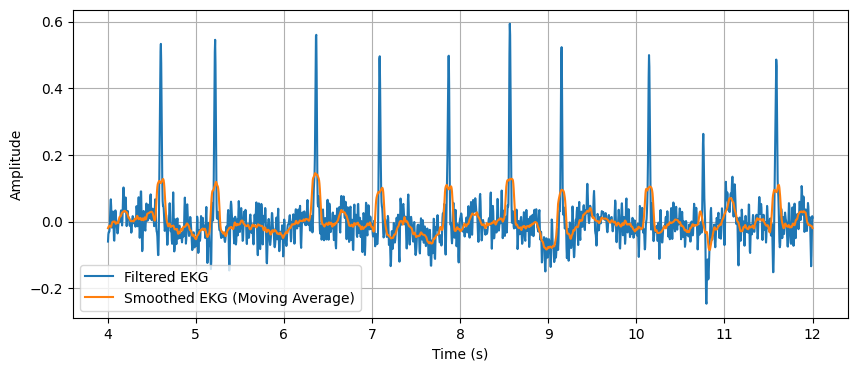

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(signal, window_size):
    """
    Applies moving average smoothing to the input signal.
    """
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

# Apply moving average to the filtered EKG signal
window_size = 25  # Adjust the window size as needed
smoothed_ekg = moving_average(filtered_ekg, window_size)

# Plot the original, filtered, and smoothed EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[1000:3000], filtered_ekg[1000:3000], label='Filtered EKG')
plt.plot(timestamps[1000:3000], smoothed_ekg[1000:3000], label='Smoothed EKG (Moving Average)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

[comments]
* qrs location is not accurate. some issue on merging boundary.
* apply moving average to mitigate the issue

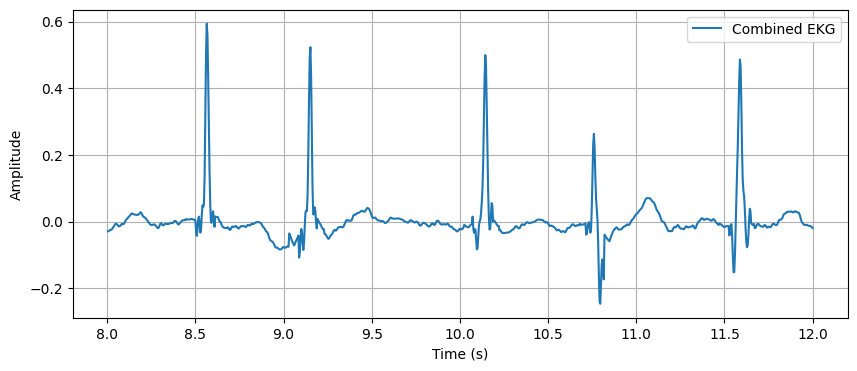

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt, find_peaks
from scipy.interpolate import interp1d

def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def pan_tompkins_qrs_detect(signal, fs):
    # Bandpass filter
    filtered_signal = bandpass_filter(signal, 5, 15, fs)

    # Differentiation
    diff_signal = np.diff(filtered_signal)

    # Squaring
    squared_signal = diff_signal ** 2

    # Moving average
    window_size = int(0.12 * fs)  # 120 ms window
    averaged_signal = np.convolve(squared_signal, np.ones(window_size) / window_size, mode='same')

    # Thresholding
    threshold = np.mean(averaged_signal) * 0.5  # Adjust the threshold as needed
    peaks, _ = find_peaks(averaged_signal, height=threshold, distance=int(0.2 * fs))  # 200 ms minimum distance

    return peaks

# Detect QRS complexes using Pan-Tompkins algorithm
qrs_peaks = pan_tompkins_qrs_detect(filtered_ekg, fs)

# Combine the baseline from the moving average signal with the peak area from the original signal
from scipy.signal import find_peaks

from scipy.signal import find_peaks

# Combine the baseline from the moving average signal with the peak area from the original signal
combined_ekg = smoothed_ekg.copy()

for peak in qrs_peaks:
    # Set the initial window around the R-peak
    orig_start = max(0, peak - int(0.1 * fs))  # 100 ms before the peak
    orig_end = min(len(filtered_ekg), peak + int(0.1 * fs))  # 100 ms after the peak
    
    # Find the local minimum after the R-peak
    window_after_peak = filtered_ekg[peak:orig_end]
    inv_window_after_peak = -window_after_peak  # Invert the window for finding peaks
    min_peaks, _ = find_peaks(inv_window_after_peak)
    
    if len(min_peaks) > 0:
        updated_end = min(peak + min_peaks[0] + int(0.025 * fs), orig_end)  # Update the end index and add space
    else:
        updated_end = orig_end
    
    # Find the local minimum before the R-peak
    window_before_peak = filtered_ekg[orig_start:peak]
    inv_window_before_peak = -window_before_peak  # Invert the window for finding peaks
    min_peaks, _ = find_peaks(inv_window_before_peak)
    
    if len(min_peaks) > 0:
        updated_start = max(orig_start + min_peaks[-1] - int(0.025 * fs), orig_start)  # Update the start index and add space
    else:
        updated_start = orig_start
    
    # Merge the filtered EKG signal with the smoothed EKG signal within the updated window using weights
    window_size = updated_end - updated_start
    combined_ekg[updated_start:updated_end] = filtered_ekg[updated_start:updated_end]
     
    # Apply moving average to the gap periods
    if updated_start > orig_start:
        gap_size = updated_start - orig_start
        window_size = min(gap_size, 20)  # Adjust the window size as needed
        weights = np.ones(window_size) / window_size
        
        filtered_gap = np.convolve(filtered_ekg[orig_start:updated_start], weights, mode='same')
        smoothed_gap = np.convolve(smoothed_ekg[orig_start:updated_start], weights, mode='same')
        
        combined_ekg[orig_start:updated_start] = smoothed_gap * 0.80 + filtered_gap * 0.20
    
    if updated_end < orig_end:
        gap_size = orig_end - updated_end
        window_size = min(gap_size, 20)  # Adjust the window size as needed
        weights = np.ones(window_size) / window_size
        
        filtered_gap = np.convolve(filtered_ekg[updated_end:orig_end], weights, mode='same')
        smoothed_gap = np.convolve(smoothed_ekg[updated_end:orig_end], weights, mode='same')
        
        combined_ekg[updated_end:orig_end] = smoothed_gap * 0.80 + filtered_gap * 0.20

# Plot the original, smoothed, and combined EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[2000:3000], combined_ekg[2000:3000], label='Combined EKG')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

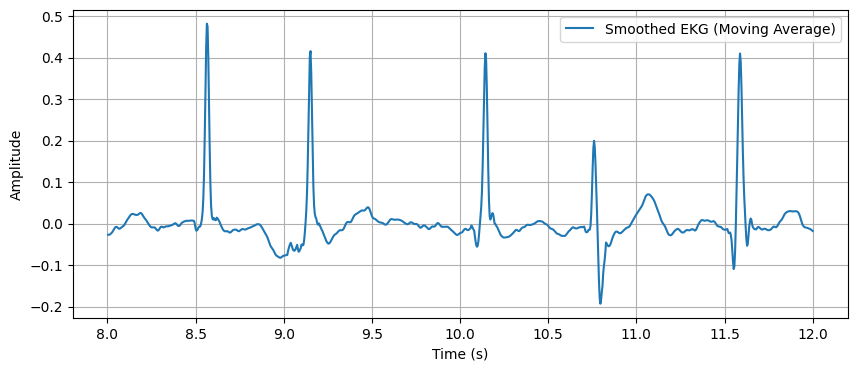

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(signal, window_size):
    """
    Applies moving average smoothing to the input signal.
    """
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

# Apply moving average to the filtered EKG signal
window_size = 5 # Adjust the window size as needed
smoothed_ekg = moving_average(combined_ekg, 5)

# Plot the original, filtered, and smoothed EKG signals
plt.figure(figsize=(10, 4))
plt.plot(timestamps[2000:3000], smoothed_ekg[2000:3000], label='Smoothed EKG (Moving Average)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()